<font color = red><b> To do list </b> </font>
<br>
[ ] Decision tree

Import Packages<br>


In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import chi2
print ("Leo_test")

Leo_test


Parameter setting
1. Folder path
2. Metadat

In [246]:
root_folder = 'HM1/'
train_file = 'train.csv'
test_file = 'test.csv'
Index = 'TransactionID'
Target = 'isFraud'

Read data

In [247]:
train = pd.read_csv(root_folder + train_file)
test = pd.read_csv(root_folder + test_file)
#print (train.columns)
train.shape

(472432, 27)

Basic statistics

In [248]:
size = train.shape
Columns = train.columns.values
Columns = Columns[Columns != Index]
Categoric_features = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2']
Numeric_features = np.setdiff1d(Columns, Categoric_features)
MissingData = pd.DataFrame(index = Columns)
for i in Columns:
  #fig, ax  = plt.subplots(figsize= (5,3))
  #plt.hist(train[i])
  # if i in Numeric_features:
  #       identify = 'Numeric'
  # else:
  #   identify = 'Categoric'
  # plt.title(f"{i:}, {identify}")
  # if i == 'isFraud':
  #       continue
  tmp_df = train[(train[i]=='NotFound') | (train[i].isna())] #test[(test[i]=='NotFound') | (test[i].isna())]
  MissingData.loc[i,0] = tmp_df.shape[0]
Categoric_features.append('Num_Cat')
print (Numeric_features)
print (Categoric_features)
MissingData

['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'TransactionAmt' 'TransactionDT' 'isFraud']
['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'Num_Cat']


0
ProductCD           0.0
card1               0.0
card2            7203.0
card3            1258.0
card4            1269.0
card5            3404.0
card6            1261.0
addr1           52428.0
addr2           52428.0
TransactionDT       0.0
TransactionAmt      0.0
C1                  0.0
C2                  0.0
C3                  0.0
C4                  0.0
C5                  0.0
C6                  0.0
C7                  0.0
C8                  0.0
C9                  0.0
C10                 0.0
C11                 0.0
C12                 0.0
C13                 0.0
C14                 0.0
isFraud             0.0

Dealing with missing data in <font color = 'red'> <b>train phase </font>

In [249]:
############# 1. remove missing records ############
train_filter = train.copy() 
############# 1. remove missing records ############


############# 2. Use most frequency values ############
train_Impu = train.copy() 
#test_Impu = test.copy()
############# 2. Use most frequency values ############

for i in tqdm(Columns):
  train_filter = train_filter[train_filter[i]!='NotFound']
  train_Impu.loc[train_Impu[i]=='NotFound',i] = train_Impu[i].value_counts().idxmax()
  # if i != 'isFraud':
  #   test_Impu[test_Impu[i]=='NotFound'] = test[i].value_counts().idxmax()
print (train_filter.shape[0]/size[0])


100%|██████████| 26/26 [00:03<00:00,  8.28it/s]

0.871657720052833


Information gain function

In [250]:
def Info_Gain(Input_Dataframe, Split_feature, IG_methods, Num_Cat): #IG_methods = 'Gini'/ 'Entropy' / 'MisEr'

  #print (Input_Dataframe)
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  #print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = float(len(Fraud_arr[Fraud_arr == 1])/length)
  #print (Fraud_arr)
  #print ("P_F = ", P_isF)
  P_notF = 1-P_isF
  Impu_root = 0
  Impu_leaves = [] #Impurity of each leaves
  Prop_leaves = [] #Propotion of each leaves
  IG_feature_Num = [] #IGs for numeric features
  #print ('Pass line 10')
  if Num_Cat == 'Cat' or Num_Cat == 'Mid':
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    #print ("FC = " , Feature_classes)
    if IG_methods == 'Gini':
      Impu_root = 1 - np.power(P_isF,2)  - np.power(P_notF,2)
      #print ("Impu_root:", Impu_root)
      #print ('Pass line 15')
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Impu_leaves.append(1 - Sub_P_isF ** 2  - Sub_P_notF ** 2)
        Prop_leaves.append(Sub_len/length)
    elif IG_methods == 'MisEr':
      Impu_root = 1 - max(P_isF,P_notF)
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Impu_leaves.append(1 - max(Sub_P_isF,Sub_P_notF))
        Prop_leaves.append(Sub_len/length)
    elif IG_methods == 'Entropy':
      if P_isF == 0:
        Ent_P_isF = 0
      else:
        Ent_P_isF = P_isF * np.log2(P_isF)
      if P_notF == 0:
        Ent_P_notF = 0
      else:
        Ent_P_notF = P_notF * np.log2(P_notF)
      Impu_root = -(Ent_P_notF + Ent_P_isF)
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        if Sub_P_isF == 0:
          Ent_Sub_P_isF = 0
        else:
          Ent_Sub_P_isF = Sub_P_isF * np.log2(Sub_P_isF)
        if Sub_P_notF == 0:
          Ent_sub_P_isF = 0
        else:
          Ent_Sub_P_not_F = Sub_P_notF * np.log2(Sub_P_notF)
        Impu_leaves.append(-(Ent_Sub_P_isF + Ent_Sub_P_not_F))
        Prop_leaves.append(Sub_len/length)
    
  elif Num_Cat == 'Num':
    Sort_Input = np.unique(Input_Dataframe[Split_feature])
    Sort_Input = Sort_Input.astype(np.float32)
    #print (Sort_Input)    
    for i in Sort_Input:
      tmp_Input_Dataframe = Input_Dataframe.copy()
      #print ("i = ", i)
      tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] <= i,Split_feature] = 0
      tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] > i,Split_feature] = 1
      #print (tmp_Input_Dataframe)
      IG_feature_Num.append(Info_Gain(tmp_Input_Dataframe,Split_feature, IG_methods, 'Mid'))
      #return Info_Gain(tmp_Input_Dataframe,'Num_Cat', IG_methods)
    
    #return IG_feature_Num

  Impu_root = np.array(Impu_root)
  Prop_leaves = np.array(Prop_leaves)
  IG_feature =  float(f"{Impu_root - np.matmul(Impu_leaves,Prop_leaves.T):.5f}")
  #print (IG_feature)
  #print (Impu_root)
  #print (Impu_leaves)
  #print (Prop_leaves)
  
  if Num_Cat == 'Num':
    #print (IG_feature_Num)
    IG_feature = max(IG_feature_Num)
    return [IG_feature, Sort_Input[IG_feature_Num.index(IG_feature)]] 
  elif Num_Cat == 'Mid':
    #print (IG_feature)
    return IG_feature
  elif Num_Cat == 'Cat':
    return [IG_feature, -3.1415926] # -pi means it is a categorical feature
  

Chi-Square 

In [251]:
def Chi_test(Input_Dataframe, Split_feature, *Split_pts_Num):
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  #print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = float(len(Fraud_arr[Fraud_arr == 1])/length)
  #print (P_isF)
  P_notF = 1-P_isF
  if (P_isF == 1) or (P_notF == 1):
    return 0
  Chi_sq = 0
  alpha = 0.05
  #print (Split_feature)
  if Split_feature in Categoric_features:
    #print ('in')
    
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    #print (Feature_classes)
    Degree_Freedom = (len(Feature_classes) - 1) * (2-1) # 2: T/F in isFraud
    #print (Degree_Freedom)
    for i in Feature_classes:
      Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
      #print (Sub_df)
      Sub_len = len(Sub_df)
      Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
      #print (Sub_P_isF)
      Sub_P_notF = 1-Sub_P_isF
      Chi_sq = Chi_sq + Sub_len * ((Sub_P_isF - P_isF)**2/P_isF + (Sub_P_notF - P_notF)**2/P_notF)
    Chi_basic = chi2.ppf(1 - alpha, Degree_Freedom)
    
  elif Split_feature in Numeric_features:
    Degree_Freedom = 1*1
    tmp_Input_Dataframe = Input_Dataframe.copy()
    #print (tmp_Input_Dataframe)
    #print (Split_pts_Num)
    Split_pts_Num = Split_pts_Num
    #tmp_Input_Dataframe[Split_feature] < 2
    tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] <= Split_pts_Num,'Num_Cat'] = 0
    tmp_Input_Dataframe.loc[tmp_Input_Dataframe[Split_feature] > Split_pts_Num,'Num_Cat'] = 1
    Chi_sq = Chi_test(tmp_Input_Dataframe,'Num_Cat')
    Chi_basic = chi2.ppf(1 - alpha, Degree_Freedom)
  
  if Split_feature != 'Num_Cat':
    if Chi_sq > Chi_basic:
      print (Chi_sq, Chi_basic)
      return 1  # good result, expanding
    else:
      print (Chi_sq, Chi_basic)
      return 0  # bad result, not expanding
  if Split_feature == 'Num_Cat':
      return Chi_sq


In [158]:
Chi_test(test,'C1',25)
#Chi_test(test,'ProductCD')

10.0 3.841458820694124


1

Build one DT

In [256]:
class TreeNode:
    # Self_Column: feature
    # Sub_branches: line connecting two nodes
    def __init__(self, Self_Column = None, Sub_branches = None, Target = None, Sub_childs = None):
        self.Self_Column = Self_Column 
        self.Sub_branches = Sub_branches if Sub_branches is not None else []
        self.Target = Target
        self.Sub_childs = Sub_childs if Sub_childs is not None else []

    def is_leaf_node(self):
        return self.Target is not None
    
    def set_values(self, column, branch):
        self.Self_Column = column
        self.Sub_branches = branch
    
    def set_Target(self, target):
        self.Target = target
    
    def add_child(self, node):
        self.Sub_childs.append(node)
    
    def get_branch(self):
        #print ('Column, Branches, Target')
        #print (self.Self_Column, self.Sub_branches, self.Target)
        return self.Sub_branches
    
    def get_child(self):
        return self.Sub_childs
    
    def get_column(self):
        return self.Self_Column
    
    def get_target(self):
        return self.Target
    
    
def build_DT(Input_Dataframe, depth = 0):
    Root_node = TreeNode()
    self_col = Input_Dataframe.columns.values
    depth = depth
    
    IG_columns = pd.DataFrame(columns= ['Column', 'IG', 'SplitPts'])
    n = 0
    for i in self_col:
        #print (i)
        if i == 'isFraud' or i == 'TransactionID':
            continue
        elif i in Categoric_features:
            [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Cat')
        elif i in Numeric_features:
            [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Num')
        IG_columns.loc[n,'Column'] = i
        IG_columns.loc[n,'IG'] = tmp_IG
        IG_columns.loc[n,'SplitPts'] = Split_pts
        n = n + 1

    #print (IG_columns)
    Best_IG = IG_columns['IG'].max()
    [Best_Column, Split_Pts] = IG_columns.loc[IG_columns['IG'] == Best_IG, ['Column', 'SplitPts']].values[0]
    #print (Best_Column,Split_Pts)
    
    if Best_Column in Categoric_features:
        Root_node.set_values(Best_Column, np.unique(Input_Dataframe[Best_Column]))
        
    elif Best_Column in Numeric_features:
        Root_node.set_values(Best_Column, Split_Pts)
    if not Chi_test(Input_Dataframe, Best_Column, Split_Pts):
        Root_node.set_Target(Input_Dataframe[Target].mode()[0])
        print ('fail chi_test:', depth)
        return Root_node
    else:
        depth = depth + 1

        print ('pass chi_test:', depth)
        if depth < 5:
            print ('in, Self_Col:', Root_node.get_column())
            print ('in, Self_branch:', Root_node.get_branch())
            #print ('in, Self_branch_len:', len(Root_node.get_branch()))
            if Root_node.Self_Column in Categoric_features:                
                for i in Root_node.Sub_branches:
                    #print ('Current Sub_Branch = ',i)
                    Sub_DF = Input_Dataframe[Input_Dataframe[Root_node.Self_Column] == i]                    
                    Root_node.add_child(build_DT(Sub_DF, depth))
                
                print ("cat:", depth)
            elif Root_node.Self_Column in Numeric_features:
                
                Sub_DF_left = Input_Dataframe[Input_Dataframe[Root_node.Self_Column] <= Root_node.Sub_branches]
                Root_node.add_child(build_DT(Sub_DF_left,depth))
                Sub_DF_right = Input_Dataframe[Input_Dataframe[Root_node.Self_Column] > Root_node.Sub_branches]
                Root_node.add_child(build_DT(Sub_DF_right,depth))
                
                
                print ("num:", depth)
        
        return Root_node

Search the Tree to predict

In [ ]:
def pedc(Input_Dataframe,Tree_node):
    self_col = Tree_node.get_column()
    self_child = Tree_node.get_child()
    tmp_node = Tree_node
    while not tmp_node.is_leaf_node():
        Input_Dataframe.loc[0,tmp_node.get_column()]
    


In [258]:
tree_node.is_leaf_node()

False

In [18]:
Info_Gain(test,'C1','Gini','Num')
Chi_test(test,'C1',25)

100%|██████████| 10/10 [00:00<00:00, 1346.62it/s]

10.0 3.841458820694124


1

In [9]:
def fun_test(a = 0):
    a=a
    return a

fun_test(10)

10

In [23]:
test = pd.DataFrame({
    'ProductCD': ['Red', 'Red', 'Green', 'Red'],
    'card1': ['Small', 'Small', 'Large', 'Large'],
    'C1': [1,0,1,0],
    'isFraud': [1, 1, 0, 0]
    #'isFraud': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
})
test

ProductCD  card1  C1  isFraud
0       Red  Small   1        1
1       Red  Small   0        1
2     Green  Large   1        0
3       Red  Large   0        0

In [64]:
test = train_filter.sample(frac = 1)[0:40000]
tree_node = build_DT(test)
a = tree_node.get_child()

100%|██████████| 27/27 [05:20<00:00, 11.87s/it]


6264.097336394529 5098.525256305482
pass chi_test: 1
in, Self_Col: card1
in, Self_branch: [ 1004  1009  1011 ... 18385 18387 18395]


100%|██████████| 27/27 [00:00<00:00, 496.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]

fail chi_test:

 1


100%|██████████| 27/27 [00:00<00:00, 368.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 153.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 197.70it/s]


44.0 9.487729036781154
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '220.0' '269.0' '327.0' '485.0']


100%|██████████| 27/27 [00:00<00:00, 221.12it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 330.37it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 210.80it/s]


34.0 19.67513757268249
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '126.0' '181.0' '184.0' '204.0' '269.0' '272.0' '315.0' '325.0'
 '327.0' '330.0' '441.0']


100%|██████████| 27/27 [00:00<00:00, 457.75it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 409.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 423.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 371.08it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 381.54it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 483.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


14.809782608695652 24.995790139728616
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 109.88it/s]


17.482709750566894 14.067140449340169
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['126.0' '184.0' '204.0' '231.0' '272.0' '299.0' '325.0' '330.0']


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.50it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 115.51it/s]


1.5962121212121212 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 183.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 398.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 90.74it/s]


57.82893505521244 35.17246162690806
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '126.0' '177.0' '181.0' '191.0' '204.0' '205.0' '220.0' '225.0'
 '226.0' '251.0' '264.0' '269.0' '272.0' '299.0' '310.0' '315.0' '325.0'
 '327.0' '387.0' '433.0' '469.0' '502.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 404.32it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


5.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 1014884.0


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 251.97it/s]


13.000000000000002 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 12601599.0


100%|██████████| 27/27 [00:00<00:00, 324.38it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 249.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 259.21it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 332.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 324.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 212.45it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 430.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 470.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 354.05it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 398.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.47it/s]


1.3333333333333333 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 311.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 334.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 437.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 192.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]

fail chi_test:

 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 313.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 296.03it/s]


13.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 3.0


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 410.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 236.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 82.23it/s]


10.941183574879227 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 242.95it/s]


13.44254036561729 3.841458820694124
pass chi_test: 3
in, Self_Col: C2
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 262.67it/s]


10.312499999999996 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 226.0


100%|██████████| 27/27 [00:00<00:00, 264.25it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


3.0 3.841458820694124
fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 381.55it/s]


4.952380952380952 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 7050379.0


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


5.1428571428571415 3.841458820694124
pass chi_test: 5


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 94.54it/s] 


3.778829095209934 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 207.57it/s]


22.0 16.918977604620448
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '181.0' '204.0' '264.0' '299.0' '310.0' '325.0' '330.0' '472.0'
 '485.0']


100%|██████████| 27/27 [00:00<00:00, 564.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]

fail chi_test: 2



100%|██████████| 27/27 [00:00<00:00, 313.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 634.20it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.72it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 138.91it/s]


31.558922558922564 38.885138659830055
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


2.9621212121212115 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 169.29it/s]


42.00000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'W']


100%|██████████| 27/27 [00:00<00:00, 313.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 433.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 307.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 154.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 289.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 326.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 277.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 96.91it/s]


51.17578125000001 49.80184956820181
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['122.0' '123.0' '126.0' '143.0' '170.0' '181.0' '184.0' '191.0' '194.0'
 '204.0' '205.0' '226.0' '231.0' '251.0' '264.0' '269.0' '272.0' '299.0'
 '308.0' '315.0' '325.0' '327.0' '330.0' '337.0' '343.0' '377.0' '387.0'
 '420.0' '428.0' '433.0' '441.0' '472.0' '476.0' '485.0' '498.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 366.07it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


4.8 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 5874698.0


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


4.0 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 107.0


100%|██████████| 27/27 [00:00<00:00, 451.48it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 651.21it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 413.75it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 376.24it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 301.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 371.10it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 148.02it/s]


26.55810147299509 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 447.65it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 175.33it/s]


47.0 3.841458820694124
pass chi_test: 3
in, Self_Col: C6
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 167.20it/s]


fail chi_test: 3
num: 3
cat: 2


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


4.0 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'W']


100%|██████████| 27/27 [00:00<00:00, 506.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 121.47it/s]


48.62068965517241 37.65248413348277
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '126.0' '143.0' '177.0' '181.0' '184.0' '191.0' '204.0' '225.0'
 '226.0' '264.0' '269.0' '272.0' '299.0' '310.0' '315.0' '325.0' '330.0'
 '387.0' '428.0' '436.0' '441.0' '476.0' '485.0' '494.0' '498.0']


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 386.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 392.59it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 363.59it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.22it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 366.08it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.43it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 247.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


3.0000000000000004 5.991464547107979
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 90.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 205.20it/s]


21.988636363636363 3.841458820694124
pass chi_test: 2
in, Self_Col: C2
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


21.48837209302326 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 15135138.0


100%|██████████| 27/27 [00:00<00:00, 230.54it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 419.91it/s]


2.0 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 474.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 429.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 150.07it/s]

fail chi_test: 1



100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 249.65it/s]


7.63888888888889 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


3.0000000000000004 5.991464547107979
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 254.31it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 366.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 217.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 223.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 296.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


6.000000000000002 11.070497693516351
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 157.48it/s]


28.991379310344826 33.92443847144381
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 103.12it/s]


37.32743362831861 43.77297182574219
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 500.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 253.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 292.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 86.13it/s]


34.18970365299037 3.841458820694124
pass chi_test: 2
in, Self_Col: C5
in, Self_branch: 18.0


100%|██████████| 27/27 [00:00<00:00, 96.95it/s]


22.660984464707866 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 334106.0


100%|██████████| 27/27 [00:00<00:00, 426.52it/s]


2.0 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 95.50it/s]


34.24290926970654 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 2242.0


100%|██████████| 27/27 [00:00<00:00, 93.84it/s]


10.66002415458937 7.814727903251179
pass chi_test: 5


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


2.0 3.841458820694124
fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 336.47it/s]


6.0 7.814727903251179
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 515.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 334.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 203.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 142.57it/s]


42.64550264550263 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 14420057.0


100%|██████████| 27/27 [00:00<00:00, 145.37it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 401.30it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 61.91it/s]


37.3737660109888 53.383540622969356
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 224.79it/s]


10.980392156862745 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


3.0000000000000004 5.991464547107979
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 210.80it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 322.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 296.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 224.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 497.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 351.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 161.23it/s]


23.12788259958072 19.67513757268249
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['110.0' '123.0' '143.0' '205.0' '220.0' '225.0' '264.0' '269.0' '299.0'
 '310.0' '387.0' '469.0']


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.63it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.89it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 309.56it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 289.70it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 384.22it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.20it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 166.17it/s]


27.96428571428571 31.410432844230918
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 654.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 90.86it/s]


7.897236817414149 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


4.0 5.991464547107979
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 89.33it/s]


8.70518954729481 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 3161682.0


100%|██████████| 27/27 [00:00<00:00, 193.48it/s]


12.45986394557823 15.50731305586545
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 115.76it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 419.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 35.50it/s]


15.222058956916102 54.572227758941736
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 47.87it/s]


72.94808888888889 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 349.50it/s]


8.0 12.591587243743977
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 49.92it/s]


36.24841284237257 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 15721360.0


100%|██████████| 27/27 [00:00<00:00, 49.72it/s]


13.052774740295245 33.92443847144381
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


2.0 3.841458820694124
fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.98it/s]


19.0 15.50731305586545
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['126.0' '143.0' '181.0' '184.0' '204.0' '299.0' '315.0' '325.0' '476.0']


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.82it/s]


3.2 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 207.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 338.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 381.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 196.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 318.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 289.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 190.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 177.04it/s]


9.092633228840125 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 429.99it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 184.90it/s]


6.485849056603773 19.67513757268249
fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 259.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 164.67it/s]


13.486607142857142 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 335.0


100%|██████████| 27/27 [00:00<00:00, 174.75it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 3630867.0


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 169.44it/s]


59.00000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 15801365.0


100%|██████████| 27/27 [00:00<00:00, 184.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 558.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 342.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 497.01it/s]

fail chi_test: 1



100%|██████████| 27/27 [00:00<00:00, 316.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


20.265151515151516 22.362032494826934
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 218.44it/s]


24.000000000000004 9.487729036781154
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['191.0' '204.0' '251.0' '387.0' '433.0']


100%|██████████| 27/27 [00:00<00:00, 398.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 256.76it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 492.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 254.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.69it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 289.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 259.22it/s]


9.975000000000009 19.67513757268249
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 202.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 371.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 161.23it/s]


32.992424242424256 37.65248413348277
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 143.32it/s]


44.4943820224719 3.841458820694124
pass chi_test: 2
in, Self_Col: C4
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 146.42it/s]


28.99242424242425 38.885138659830055
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 309.56it/s]


6.0 11.070497693516351
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 371.09it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 103.98it/s]


63.937500000000014 44.98534328036513
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '126.0' '143.0' '157.0' '181.0' '184.0' '191.0' '204.0' '205.0'
 '225.0' '231.0' '251.0' '260.0' '264.0' '272.0' '299.0' '308.0' '310.0'
 '315.0' '325.0' '327.0' '330.0' '337.0' '420.0' '436.0' '441.0' '472.0'
 '476.0' '485.0' '492.0' '502.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 387.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 335.0


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.36it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.35it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 378.82it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


8.0 3.841458820694124
pass chi_test: 3
in, Self_Col: ProductCD
in, Self_branch: ['S' 'W']


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 345.03it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 368.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 615.72it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.49it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 363.56it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 351.81it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.59it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 366.09it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 313.15it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 320.56it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 601.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 313.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 306.07it/s]


2.4374999999999996 5.991464547107979
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 143.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 207.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 134.77it/s]


22.323529411764707 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 430.00it/s]


0.75 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 151.32it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 447.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 299.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 145.63it/s]


18.321428571428573 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 335.0


100%|██████████| 27/27 [00:00<00:00, 146.16it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 178.20it/s]


24.489795918367342 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 207.51it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 155.68it/s]


20.60493014410065 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


6.0 11.070497693516351
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


6.000000000000001 7.814727903251179
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 176.47it/s]


23.989583333333336 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 29.0


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


2.0 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 178.80it/s]


fail chi_test: 3
num: 3
cat: 2


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 227.61it/s]


19.40625 3.841458820694124
pass chi_test: 2
in, Self_Col: C11
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 386.99it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: ProductCD
in, Self_branch: ['H' 'W']


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 3
cat: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 126.87it/s]


7.082544455581541 3.841458820694124
pass chi_test: 2
in, Self_Col: C9
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 153.48it/s]


6.3875 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 210.0


100%|██████████| 27/27 [00:00<00:00, 167.20it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 324.39it/s]


10.0 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 226.0


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 401.29it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 230.53it/s]


7.2 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 59.0


100%|██████████| 27/27 [00:00<00:00, 407.31it/s]


3.0 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 289.57it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 232.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 249.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 79.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


4.0 7.814727903251179
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 356.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 275.00it/s]


9.0 11.070497693516351
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 240.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 256.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 611.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 270.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 575.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 231.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.64it/s]


16.0 19.67513757268249
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 361.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 240.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 398.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 136.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


4.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 4394341.0


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 371.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 288.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 429.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 296.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 356.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 83.99it/s]


160.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C4
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 86.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 236.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 454.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 361.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.51it/s]


7.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['S' 'W']


100%|██████████| 27/27 [00:00<00:00, 634.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 376.26it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 282.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 482.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 296.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 347.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 178.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 71.10it/s]


10.61698906644239 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 10952911.0


100%|██████████| 27/27 [00:00<00:00, 93.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 152.18it/s]


13.736842105263158 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 11042534.0


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 150.49it/s]


4.827505827505828 16.918977604620448
fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.44it/s]


3.428571428571429 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 351.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 199.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 218.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 322.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


6.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 250.0


100%|██████████| 27/27 [00:00<00:00, 416.78it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 206.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 277.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 326.39it/s]


11.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 4.0


100%|██████████| 27/27 [00:00<00:00, 324.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 183.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 309.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.02it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 299.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 306.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 429.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 669.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 202.14it/s]


25.999999999999993 12.591587243743977
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['191.0' '251.0' '272.0' '324.0' '387.0' '441.0' '498.0']


100%|██████████| 27/27 [00:00<00:00, 271.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 280.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 652.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 173.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 259.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


11.549999999999999 15.50731305586545
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


6.0 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['S' 'W']


100%|██████████| 27/27 [00:00<00:00, 595.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 366.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.64it/s]


9.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 210.0


100%|██████████| 27/27 [00:00<00:00, 320.55it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


4.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 4147622.0


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 416.76it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 137.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 245.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 457.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 210.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


10.999999999999998 14.067140449340169
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 183.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


5.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: C2
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 547.13it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 141.82it/s]


23.251141552511406 37.65248413348277
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 309.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 381.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


10.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 390.0


100%|██████████| 27/27 [00:00<00:00, 330.36it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.67it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 43.70it/s]


79.81805838424984 3.841458820694124
pass chi_test: 2
in, Self_Col: C8
in, Self_branch: 6.0


100%|██████████| 27/27 [00:00<00:00, 44.99it/s]


31.907565863224725 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 845.0


100%|██████████| 27/27 [00:00<00:00, 46.50it/s]


29.352902864044164 56.94238714682408
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 255.53it/s]


7.9078125 19.67513757268249
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 251.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 342.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 134.10it/s]


33.97142857142857 31.410432844230918
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '181.0' '191.0' '204.0' '225.0' '264.0' '272.0' '299.0' '301.0'
 '310.0' '315.0' '325.0' '330.0' '337.0' '384.0' '387.0' '441.0' '476.0'
 '485.0' '498.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 311.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


5.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: ProductCD
in, Self_branch: ['H' 'W']


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 363.56it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 356.44it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 330.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 313.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 356.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 256.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 107.28it/s]


11.99243235525094 12.591587243743977
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 121.47it/s]


53.316455696202524 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 15.0


100%|██████████| 27/27 [00:00<00:00, 134.10it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 358.77it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 184.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 237.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]

fail chi_test: 1



100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 161.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 202.13it/s]


33.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 219.26it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 358.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 314.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.50it/s]


14.000000000000002 16.918977604620448
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 182.41it/s]


30.92275910364145 30.14352720564616
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '143.0' '177.0' '184.0' '204.0' '220.0' '251.0' '264.0' '272.0'
 '299.0' '315.0' '325.0' '327.0' '330.0' '441.0' '472.0' '476.0' '485.0'
 '502.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 384.19it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 564.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


1.875 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 515.88it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 384.20it/s]


6.999999999999998 3.841458820694124
pass chi_test: 3
in, Self_Col: card5
in, Self_branch: ['166.0' '224.0']


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 416.76it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 65.0


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


15.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 596319.0


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 320.55it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 190.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 286.65it/s]


17.0 7.814727903251179
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['184.0' '325.0' '441.0' '476.0']


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 347.30it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 154.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 381.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 381.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 64.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 222.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 240.78it/s]


15.000000000000002 21.02606981748307
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 305.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 188.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 371.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 338.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 151.75it/s]


32.63611111111111 33.92443847144381
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


5.0 3.841458820694124
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['264.0' '299.0']


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 190.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 202.90it/s]


21.079545454545464 19.67513757268249
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['191.0' '204.0' '231.0' '272.0' '299.0' '315.0' '325.0' '330.0' '384.0'
 '387.0' '433.0' '472.0']


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.58it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 416.78it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 2143301.0


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 629.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 209.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 274.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 179.99it/s]


23.489361702127663 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 441739.0


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 198.45it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 313.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 277.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 146.03it/s]


2.281706604324956 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 183.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 222.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.77it/s]


7.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'W']


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 384.20it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 334.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 59.34it/s]


95.24504716981134 23.684791304840576
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['157.0' '204.0' '225.0' '231.0' '272.0' '299.0' '315.0' '325.0' '330.0'
 '337.0' '387.0' '441.0' '476.0' '498.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 67.67it/s]


192.0 3.841458820694124
pass chi_test: 3
in, Self_Col: C4
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 67.48it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.62it/s]


5.0 3.841458820694124
pass chi_test: 3
in, Self_Col: C6
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 608.65it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


19.999999999999996 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 352314.0


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 240.78it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 368.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 194.11it/s]


33.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 475.0


100%|██████████| 27/27 [00:00<00:00, 191.43it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.68it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


4.0 5.991464547107979
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 361.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 209.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 309.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 194.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 330.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 52.44it/s]


27.5520697167756 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 2294.0


100%|██████████| 27/27 [00:00<00:00, 56.61it/s]


30.996555118110237 3.841458820694124
pass chi_test: 3
in, Self_Col: C11
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 57.18it/s]


20.760823354481406 33.92443847144381
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 685.70it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 459.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


8.0 5.991464547107979
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['181.0' '220.0' '441.0']


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 44.77it/s]


37.87832570753144 49.80184956820181
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 309.57it/s]


14.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 117.0


100%|██████████| 27/27 [00:00<00:00, 328.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 159.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


8.0 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['S' 'W']


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 245.14it/s]


14.000000000000002 18.307038053275146
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 62.53it/s]


16.5990063702033 22.362032494826934
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 239.70it/s]


26.000000000000004 3.841458820694124
pass chi_test: 2
in, Self_Col: C12
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 82.83it/s]


52.329113924050624 3.841458820694124
pass chi_test: 2
in, Self_Col: C8
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 89.22it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 356.44it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 183.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 313.13it/s]


9.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 769344.0


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 332.37it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 173.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 59.08it/s]


5.851181380039967 16.918977604620448
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 55.78it/s]


16.852760154332945 19.67513757268249
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 183.02it/s]


6.480620155038759 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


6.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 10417768.0


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 195.58it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 72.04it/s]


25.065299592786495 49.80184956820181
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 213.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:01<00:00, 17.33it/s]


383.33101851851853 3.841458820694124
pass chi_test: 2
in, Self_Col: C8
in, Self_branch: 2.0


100%|██████████| 27/27 [00:01<00:00, 17.73it/s]


84.24537131497603 66.3386488629688
pass chi_test: 3
in, Self_Col: addr1
in, Self_branch: ['110.0' '122.0' '123.0' '126.0' '143.0' '158.0' '170.0' '177.0' '181.0'
 '184.0' '191.0' '194.0' '203.0' '204.0' '205.0' '220.0' '225.0' '226.0'
 '231.0' '251.0' '264.0' '269.0' '272.0' '299.0' '308.0' '310.0' '315.0'
 '324.0' '325.0' '327.0' '330.0' '337.0' '343.0' '384.0' '387.0' '420.0'
 '428.0' '433.0' '436.0' '441.0' '444.0' '448.0' '469.0' '472.0' '476.0'
 '485.0' '492.0' '494.0' '498.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 277.82it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 732.12it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 153.91it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 277.82it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 197.71it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 347.30it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 211.61it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 230.54it/s]


13.982142857142856 3.841458820694124
pass chi_test: 4
in, Self_Col: C9
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


2.0 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 239.69it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 182.41it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 155.67it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 232.51it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 324.40it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 274.99it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 177.58it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 197.71it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 163.68it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 118.54it/s]


75.0 3.841458820694124
pass chi_test: 4
in, Self_Col: C5
in, Self_branch: 154.0


100%|██████████| 27/27 [00:00<00:00, 122.02it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 354.03it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 296.03it/s]


2.9333333333333327 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 154.78it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 363.56it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 125.41it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 219.33it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 186.18it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 194.17it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 373.59it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 205.99it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 249.66it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 202.14it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


6.000000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: C1
in, Self_branch: 3.0


100%|██████████| 27/27 [00:00<00:00, 384.21it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 217.57it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 275.00it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 178.80it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 668.77it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 179.99it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 292.84it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 313.15it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 546.77it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 256.73it/s]


12.59259259259259 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 554.0


100%|██████████| 27/27 [00:00<00:00, 296.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 430.00it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 277.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 371.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 307.84it/s]


16.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 422.5


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.77it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 234.53it/s]


16.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['C' 'H' 'W']


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 299.29it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 144.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 143.32it/s]


10.654411764705886 35.17246162690806
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.50it/s]


7.000000000000002 11.070497693516351
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 242.84it/s]


24.000000000000004 18.307038053275146
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '191.0' '204.0' '264.0' '272.0' '325.0' '337.0' '343.0' '428.0'
 '485.0' '494.0']


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 410.47it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.64it/s]


6.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['264.0' '299.0']


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 60.60it/s]


110.3131313131313 53.383540622969356
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['106.0' '110.0' '123.0' '143.0' '158.0' '177.0' '181.0' '184.0' '191.0'
 '203.0' '204.0' '205.0' '225.0' '226.0' '231.0' '251.0' '253.0' '264.0'
 '269.0' '272.0' '299.0' '310.0' '315.0' '324.0' '325.0' '327.0' '330.0'
 '337.0' '387.0' '420.0' '433.0' '436.0' '441.0' '444.0' '476.0' '485.0'
 '494.0' '498.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 245.13it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.84it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 307.84it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 320.56it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 410.45it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 564.35it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 384.21it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 245.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 368.53it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 232.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 342.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


0.75 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 299.28it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 259.21it/s]


18.0 15.50731305586545
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '191.0' '203.0' '264.0' '269.0' '310.0' '327.0' '436.0' '498.0']


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 157.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 119.86it/s]


12.959360167944505 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 445.0


100%|██████████| 27/27 [00:00<00:00, 123.69it/s]


15.790243902439025 3.841458820694124
pass chi_test: 3
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


5.000000000000001 9.487729036781154
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 130.86it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


5.333333333333333 11.070497693516351
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 410.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 299.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 148.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 88.66it/s]


8.020763811642565 3.841458820694124
pass chi_test: 2
in, Self_Col: C4
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 89.84it/s]


10.389658356417359 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 5.0


100%|██████████| 27/27 [00:00<00:00, 133.44it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 181.79it/s]


19.0 3.841458820694124
pass chi_test: 4
in, Self_Col: C5
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 189.42it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


5.454545454545455 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 389.71it/s]


2.9333333333333327 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.26it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 205.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 134.76it/s]


16.59069767441861 40.113272069413625
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 330.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


5.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 226.0


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 652.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.26it/s]


22.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 3.0


100%|██████████| 27/27 [00:00<00:00, 292.84it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


15.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['S' 'W']


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.59it/s]


5.333333333333333 9.487729036781154
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 314.99it/s]


9.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 10735537.0


100%|██████████| 27/27 [00:00<00:00, 361.21it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 277.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 195.60it/s]


42.00000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 970.0


100%|██████████| 27/27 [00:00<00:00, 205.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 148.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 210.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 110.11it/s]


46.355579631635976 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 455.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 157.48it/s]


29.929352678571426 33.92443847144381
fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 236.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 77.16it/s]


41.340566037735854 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


5.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 3289750.0


100%|██████████| 27/27 [00:00<00:00, 582.48it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 92.61it/s]


23.160839160839156 3.841458820694124
pass chi_test: 3
in, Self_Col: C6
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


6.000000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: C5
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 93.57it/s]


fail chi_test: 3
num: 3
cat: 2


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 114.78it/s]


14.196162427487728 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 564.41it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 117.26it/s]


19.990853658536583 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 250.0


100%|██████████| 27/27 [00:00<00:00, 121.17it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


4.0 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 3772843.0


100%|██████████| 27/27 [00:00<00:00, 608.59it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 4
num: 4
num: 3
cat: 2


100%|██████████| 27/27 [00:00<00:00, 668.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 338.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 194.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 191.44it/s]


30.4672131147541 3.841458820694124
pass chi_test: 2
in, Self_Col: C2
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 169.29it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 361.21it/s]


1.3333333333333333 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 313.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 306.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 156.13it/s]


17.044799999999995 7.814727903251179
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['205.0' '315.0' '325.0' '327.0']


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 153.04it/s]


11.480034722222223 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 14843648.0


100%|██████████| 27/27 [00:00<00:00, 166.70it/s]


7.148936170212764 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 29.0


100%|██████████| 27/27 [00:00<00:00, 426.57it/s]


6.000000000000001 3.841458820694124
pass chi_test: 5


100%|██████████| 27/27 [00:00<00:00, 156.57it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


2.0 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 299.30it/s]


18.0 19.67513757268249
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 147.21it/s]


28.382850241545874 40.113272069413625
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 153.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 398.38it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:01<00:00, 16.39it/s]


103.68435131334259 38.885138659830055
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['126.0' '177.0' '181.0' '184.0' '191.0' '204.0' '220.0' '231.0' '251.0'
 '253.0' '264.0' '269.0' '272.0' '299.0' '310.0' '315.0' '324.0' '325.0'
 '327.0' '330.0' '337.0' '387.0' '420.0' '433.0' '441.0' '476.0' '494.0']


100%|██████████| 27/27 [00:00<00:00, 92.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 313.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 41.93it/s]


7.05457968656098 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 527.0


100%|██████████| 27/27 [00:00<00:00, 42.52it/s]


5.241485086283368 3.841458820694124
pass chi_test: 4
in, Self_Col: C1
in, Self_branch: 11.0


100%|██████████| 27/27 [00:00<00:00, 55.79it/s]


26.086846400630375 3.841458820694124
pass chi_test: 5


100%|██████████| 27/27 [00:00<00:00, 122.28it/s]


29.0 3.841458820694124
pass chi_test: 5
num: 4


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


6.000000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: C2
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 186.17it/s]


11.594202898550725 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 7.0


100%|██████████| 27/27 [00:00<00:00, 238.66it/s]


3.4285714285714284 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 299.28it/s]


8.0 3.841458820694124
pass chi_test: 4
in, Self_Col: C1
in, Self_branch: 13.0


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 455.23it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 347.31it/s]


10.000000000000002 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 550.0


100%|██████████| 27/27 [00:00<00:00, 354.08it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 345.06it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 64.56it/s]


59.12925170068026 3.841458820694124
pass chi_test: 3
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


3.7333333333333325 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 66.80it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 429.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 194.18it/s]


8.228571428571428 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 317.5


100%|██████████| 27/27 [00:00<00:00, 192.10it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


4.0 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 7699892.0


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 80.02it/s]


25.24672963461616 3.841458820694124
pass chi_test: 3
in, Self_Col: C6
in, Self_branch: 9.0


100%|██████████| 27/27 [00:00<00:00, 101.64it/s]


7.685711570945947 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 150.0


100%|██████████| 27/27 [00:00<00:00, 129.60it/s]


2.2936780668739427 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 207.57it/s]


10.923809523809522 3.841458820694124
pass chi_test: 5
num: 4


100%|██████████| 27/27 [00:00<00:00, 205.20it/s]


17.0 3.841458820694124
pass chi_test: 4
in, Self_Col: C1
in, Self_branch: 4.0


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 13136664.0


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.77it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 104.99it/s]


19.684311740890696 3.841458820694124
pass chi_test: 3
in, Self_Col: C12
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 117.01it/s]


24.657777777777778 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 589979.0


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


3.0 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 112.62it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


5.0 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 8986418.0


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 307.84it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 239.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 197.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.55it/s]


10.999999999999998 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 349.51it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 612.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 398.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 124.83it/s]


44.06111111111108 38.885138659830055
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['110.0' '123.0' '126.0' '143.0' '181.0' '184.0' '191.0' '203.0' '204.0'
 '220.0' '225.0' '226.0' '231.0' '251.0' '264.0' '272.0' '299.0' '315.0'
 '325.0' '330.0' '337.0' '384.0' '436.0' '441.0' '444.0' '448.0' '485.0']


100%|██████████| 27/27 [00:00<00:00, 722.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.47it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.24it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


6.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 326.37it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.24it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 455.21it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 275.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 116.26it/s]


44.7454452690167 50.99846016571065
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 201.39it/s]


10.980392156862745 3.841458820694124
pass chi_test: 2
in, Self_Col: C9
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 234.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 588.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 342.91it/s]


10.999999999999998 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 124.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 237.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


4.0 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['R' 'W']


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 363.57it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.24it/s]

fail chi_test: 1



100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 76.09it/s]


94.489417989418 22.362032494826934
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['126.0' '177.0' '204.0' '220.0' '231.0' '264.0' '272.0' '299.0' '325.0'
 '330.0' '337.0' '441.0' '476.0' '499.0']


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 3470470.0


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 90.44it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 410.45it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 389.75it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 57.45it/s]


33.424985056784216 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 131866.0


100%|██████████| 27/27 [00:00<00:00, 732.15it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 53.59it/s]


38.996498599439775 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 179.0


100%|██████████| 27/27 [00:00<00:00, 58.38it/s]


18.144421502566722 22.362032494826934
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 703.46it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 51.45it/s]


20.96996871741397 52.192319730102895
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 188.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 227.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 741.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]

fail chi_test:

 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 144.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 361.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 74.83it/s]


22.48314767099193 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 316.80it/s]


8.586666666666666 16.918977604620448
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 85.85it/s]


19.02887308769661 47.39988391908093
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 588.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 256.75it/s]


7.366666666666667 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 3.0


100%|██████████| 27/27 [00:00<00:00, 328.32it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.35it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 155.0


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 376.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 624.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 296.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 498.20it/s]


3.0000000000000004 5.991464547107979
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


8.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 10797189.0


100%|██████████| 27/27 [00:00<00:00, 351.82it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 537.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 642.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 42.72it/s]


112.03911017728477 62.829620411408165
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['110.0' '123.0' '126.0' '143.0' '158.0' '170.0' '177.0' '181.0' '184.0'
 '191.0' '194.0' '203.0' '204.0' '205.0' '220.0' '225.0' '226.0' '231.0'
 '251.0' '253.0' '264.0' '269.0' '272.0' '299.0' '308.0' '310.0' '315.0'
 '324.0' '325.0' '327.0' '330.0' '337.0' '387.0' '410.0' '420.0' '433.0'
 '436.0' '441.0' '448.0' '469.0' '472.0' '476.0' '485.0' '494.0' '498.0'
 '502.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


22.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 14164786.0


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 455.16it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.21it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.64it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 245.14it/s]


6.969696969696969 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 4.0


100%|██████████| 27/27 [00:00<00:00, 313.14it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 492.52it/s]


3.0 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.39it/s]


6.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 39.0


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 506.24it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 413.53it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 197.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 351.80it/s]


3.61111111111111 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 153.90it/s]


12.1875 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 13045874.0


100%|██████████| 27/27 [00:00<00:00, 162.19it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 407.26it/s]


5.000000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 13384830.0


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 358.74it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 272.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 186.80it/s]


20.988095238095237 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 177345.0


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 175.88it/s]


20.48780487804878 3.841458820694124
pass chi_test: 4
in, Self_Col: C1
in, Self_branch: 7.0


100%|██████████| 27/27 [00:00<00:00, 199.91it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


2.0 3.841458820694124
fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


5.142857142857142 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 150.0


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 496.61it/s]


3.0 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 334.44it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 515.86it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 313.13it/s]


5.118055555555555 5.991464547107979
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.28it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.87it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 703.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 246.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 361.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 238.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.26it/s]


9.360000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 226.0


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


5.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 3093941.0


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 426.52it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 309.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.71it/s]


19.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 280.69it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 221.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 408.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 297.69it/s]


15.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 541.78it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 378.84it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 221.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 209.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 123.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.26it/s]


21.0 11.070497693516351
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['191.0' '204.0' '251.0' '272.0' '433.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.48it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 291.29it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 541.78it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 732.12it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


5.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 582.43it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 204.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 240.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 124.25it/s]


6.3875 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 151.0


100%|██████████| 27/27 [00:00<00:00, 132.13it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


10.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 8261742.0


100%|██████████| 27/27 [00:00<00:00, 336.47it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 114.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 429.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 123.96it/s]


68.00000000000003 32.670573340917315
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['181.0' '184.0' '191.0' '204.0' '205.0' '225.0' '231.0' '264.0' '272.0'
 '299.0' '310.0' '315.0' '325.0' '330.0' '337.0' '387.0' '418.0' '441.0'
 '448.0' '476.0' '494.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 547.13it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 356.42it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 401.29it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 313.15it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 239.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 398.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 356.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 78.28it/s]


48.99549549549549 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 534.0


100%|██████████| 27/27 [00:00<00:00, 80.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 404.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 274.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 124.82it/s]


37.04763851973013 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 147.21it/s]


21.65656565656565 21.02606981748307
pass chi_test: 3
in, Self_Col: addr1
in, Self_branch: ['110.0' '122.0' '158.0' '205.0' '225.0' '299.0' '310.0' '420.0' '428.0'
 '436.0' '444.0' '485.0' '492.0']


100%|██████████| 27/27 [00:00<00:00, 404.31it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 576.34it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 615.65it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 189.41it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


3.0 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 342.90it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 440.39it/s]


fail chi_test: 3
cat: 3
cat: 2


100%|██████████| 27/27 [00:00<00:00, 426.52it/s]


7.0 9.487729036781154
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


6.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 9219510.0


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 47.44it/s]


6.636651078754382 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 828.0


100%|██████████| 27/27 [00:00<00:00, 48.33it/s]


8.562853879990973 23.684791304840576
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


6.000000000000002 7.814727903251179
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 118.80it/s]


20.000347480764457 11.070497693516351
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['184.0' '324.0' '330.0' '337.0' '441.0' '494.0']


100%|██████████| 27/27 [00:00<00:00, 132.13it/s]


2.6174391201885303 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


5.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 59.0


100%|██████████| 27/27 [00:00<00:00, 582.42it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.84it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 175.32it/s]


54.0 19.67513757268249
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['126.0' '184.0' '204.0' '231.0' '251.0' '264.0' '272.0' '308.0' '324.0'
 '325.0' '330.0' '433.0']


100%|██████████| 27/27 [00:00<00:00, 447.68it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 292.82it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 361.19it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 629.94it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.20it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 741.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 272.23it/s]


15.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 25.0


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.92it/s]


2.4000000000000004 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 366.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 366.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 214.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 198.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 307.84it/s]


11.999999999999998 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 12416105.0


100%|██████████| 27/27 [00:00<00:00, 376.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.57it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 313.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 168.24it/s]


20.48780487804878 28.869299430392623
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 94.54it/s]


72.99657534246575 3.841458820694124
pass chi_test: 2
in, Self_Col: C10
in, Self_branch: 3.0


100%|██████████| 27/27 [00:00<00:00, 92.92it/s]


13.693793103448279 3.841458820694124
pass chi_test: 3
in, Self_Col: C11
in, Self_branch: 3.0


100%|██████████| 27/27 [00:00<00:00, 105.81it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 299.30it/s]


10.0 3.841458820694124
pass chi_test: 4
in, Self_Col: C6
in, Self_branch: 4.0


100%|██████████| 27/27 [00:00<00:00, 685.59it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 660.76it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 637.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 226.67it/s]


7.638888888888888 3.841458820694124
pass chi_test: 2
in, Self_Col: C12
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 261.71it/s]


4.363636363636364 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 11214392.0


100%|██████████| 27/27 [00:00<00:00, 283.64it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 363.56it/s]


4.444444444444444 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 12053014.0


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


3.0 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 515.83it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 410.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 289.70it/s]


17.0 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 525.88it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 328.33it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 114.78it/s]


26.658436213991752 32.670573340917315
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 195.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 238.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 140.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 396.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 205.99it/s]

27.000000000000004

 27.58711163827534
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.84it/s]


13.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 14151098.0


100%|██████████| 27/27 [00:00<00:00, 324.36it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 306.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.80it/s]


9.0 15.50731305586545
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 202.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 366.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 279.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 292.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 115.76it/s]


31.32631578947366 43.77297182574219
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 56.55it/s]


7.3397075365579285 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 223.0


100%|██████████| 27/27 [00:00<00:00, 65.82it/s]


10.073235953319422 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 15.0


100%|██████████| 27/27 [00:00<00:00, 72.52it/s]


8.703230544532627 3.841458820694124
pass chi_test: 4
in, Self_Col: C6
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 261.71it/s]


3.141818181818182 5.991464547107979
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 78.74it/s]


12.39530988274707 3.841458820694124
pass chi_test: 5
num: 4


100%|██████████| 27/27 [00:00<00:00, 401.26it/s]


5.000000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 6303383.0


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 440.35it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 245.13it/s]


9.0332383665717 5.991464547107979
pass chi_test: 3
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 234.52it/s]


9.504000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 250.0


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


5.000000000000001 5.991464547107979
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 288.19it/s]


fail chi_test: 4
num: 4
cat: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 204.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 32.19it/s]


41.74820613176777 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 31.12it/s]


13.929291815795752 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 15543336.0


100%|██████████| 27/27 [00:00<00:00, 32.79it/s]


11.082444061962134 3.841458820694124
pass chi_test: 4
in, Self_Col: C4
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 32.67it/s]


11.312654595104746 3.841458820694124
pass chi_test: 5


100%|██████████| 27/27 [00:00<00:00, 351.83it/s]


4.0 5.991464547107979
fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


3.0 3.841458820694124
fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 249.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 56.31it/s]


35.66927390791029 54.572227758941736
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 188.76it/s]


16.32 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 501.0


100%|██████████| 27/27 [00:00<00:00, 205.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


3.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 199.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 135.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 222.00it/s]


35.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 6.0


100%|██████████| 27/27 [00:00<00:00, 242.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 496.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 126.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 209.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 33.65it/s]


13.621632582657174 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 750.0


100%|██████████| 27/27 [00:00<00:00, 34.82it/s]


14.399205957277667 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 15111102.0


100%|██████████| 27/27 [00:00<00:00, 35.62it/s]


11.138657816556607 22.362032494826934
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 288.19it/s]


7.200000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 15261066.0


100%|██████████| 27/27 [00:00<00:00, 307.83it/s]


3.0 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 349.52it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


3.428571428571429 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 429.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 269.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 313.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 41.64it/s]


12.739259670810474 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 15169191.0


100%|██████████| 27/27 [00:00<00:00, 44.19it/s]


18.700873739466786 40.113272069413625
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 354.06it/s]


7.96875 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 15188482.0


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 289.69it/s]


4.622222222222222 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 15366371.0


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


3.0 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 384.21it/s]


fail chi_test: 4
num: 4
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 622.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 156.57it/s]


8.150943396226415 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 13809357.0


100%|██████████| 27/27 [00:00<00:00, 157.03it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 384.21it/s]


6.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: ProductCD
in, Self_branch: ['S' 'W']


100%|██████████| 27/27 [00:00<00:00, 712.86it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 3
cat: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 608.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 301.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


8.0 12.591587243743977
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 398.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 79.20it/s]


10.058628714643755 16.918977604620448
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 741.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 741.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 161.23it/s]


7.935828877005349 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 387.01it/s]


6.518518518518519 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 7423103.0


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


3.0 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 178.20it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 121.47it/s]


8.223964129610811 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 1132054.0


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 132.13it/s]


3.250240981722463 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 247.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 110.78it/s]


6.438159375899891 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 5.0


100%|██████████| 27/27 [00:00<00:00, 123.12it/s]


9.291089108910896 5.991464547107979
pass chi_test: 3
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


2.592592592592592 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 137.50it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 324.38it/s]


7.000000000000002 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 97.94


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 525.85it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 134.76it/s]


69.0 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 144.85it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 342.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]

fail chi_test:

 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 371.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 130.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 299.31it/s]


16.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 242.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]

fail chi_test:

 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 275.00it/s]


19.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 582.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 234.52it/s]


20.91503267973856 3.841458820694124
pass chi_test: 2
in, Self_Col: C2
in, Self_branch: 4.0


100%|██████████| 27/27 [00:00<00:00, 340.70it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


8.999999999999996 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 3329236.0


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 407.28it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 356.45it/s]


8.0 12.591587243743977
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 741.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.97it/s]


6.300000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: C4
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 286.63it/s]


2.716049382716049 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 174.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 121.19it/s]


18.73735031202564 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 15362497.0


100%|██████████| 27/27 [00:00<00:00, 119.85it/s]


18.490131578947363 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 15.0


100%|██████████| 27/27 [00:00<00:00, 440.39it/s]


4.0 3.841458820694124
pass chi_test: 4
in, Self_Col: ProductCD
in, Self_branch: ['S' 'W']


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 582.42it/s]


fail chi_test: 4
cat: 4


100%|██████████| 27/27 [00:00<00:00, 128.37it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


2.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 306.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


3.0000000000000004 5.991464547107979
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 338.62it/s]


9.0 9.487729036781154
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


32.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C12
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 245.13it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 347.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 223.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 226.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


7.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 373.59it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 272.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.36it/s]


8.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 582.43it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 259.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 245.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 226.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 143.32it/s]


35.97484276729559 38.885138659830055
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


7.638888888888892 26.29622760486423
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 334.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 164.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 366.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 209.17it/s]


27.59072580645161 24.995790139728616
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '143.0' '181.0' '184.0' '191.0' '226.0' '264.0' '272.0' '299.0'
 '310.0' '315.0' '325.0' '327.0' '330.0' '433.0' '436.0']


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 75.0


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.22it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 463.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.67it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 164.17it/s]


18.98684210526316 15.50731305586545
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['126.0' '204.0' '264.0' '324.0' '325.0' '330.0' '337.0' '420.0' '433.0']


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 455.24it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.89it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 173.09it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.57it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 92.29it/s]


22.695474519203334 27.58711163827534
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 356.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.21it/s]


5.454545454545455 11.070497693516351
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 322.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 575.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 498.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 269.53it/s]


11.250000000000002 16.918977604620448
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 151.32it/s]


14.237288135593221 3.841458820694124
pass chi_test: 2
in, Self_Col: C12
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 147.21it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 59.0


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 151.32it/s]


29.006802721088437 37.65248413348277
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 226.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 347.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 578.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 220.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 292.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 201.40it/s]


11.979166666666668 3.841458820694124
pass chi_test: 2
in, Self_Col: C8
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 215.10it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


2.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 292.84it/s]


19.0 21.02606981748307
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 135.44it/s]


16.677811550151972 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 264.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 170.36it/s]


18.200000000000003 3.841458820694124
pass chi_test: 3
in, Self_Col: C5
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 342.91it/s]


9.230769230769235 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 32.0


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 309.57it/s]


13.000000000000009 3.841458820694124
pass chi_test: 5
num: 4


100%|██████████| 27/27 [00:00<00:00, 245.14it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 629.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 199.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


3.0000000000000004 5.991464547107979
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 272.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 289.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 398.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.81it/s]


10.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 14156004.0


100%|██████████| 27/27 [00:00<00:00, 324.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 280.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 311.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 120.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 654.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 219.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 317.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.37it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 103.58it/s]


44.46896551724139 43.77297182574219
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['110.0' '122.0' '123.0' '126.0' '143.0' '177.0' '181.0' '184.0' '191.0'
 '204.0' '225.0' '226.0' '231.0' '264.0' '299.0' '310.0' '315.0' '325.0'
 '327.0' '330.0' '337.0' '343.0' '387.0' '420.0' '428.0' '433.0' '441.0'
 '469.0' '472.0' '498.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 342.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 389.74it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 190.75it/s]


14.482758620689657 3.841458820694124
pass chi_test: 3
in, Self_Col: C8
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 234.52it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


2.0 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 309.56it/s]


6.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 351.82it/s]


5.625 5.991464547107979
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.45it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:01<00:00, 26.50it/s]


59.96717167396495 68.66929391228578
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 162.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 147.21it/s]


48.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 312.0


100%|██████████| 27/27 [00:00<00:00, 169.29it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 349.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 222.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


4.0 7.814727903251179
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 272.23it/s]


15.272727272727277 19.67513757268249
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 240.78it/s]


8.470588235294116 15.50731305586545
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 230.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 164.67it/s]


5.08119658119658 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 358.75it/s]


12.000000000000002 3.841458820694124
pass chi_test: 3
in, Self_Col: C9
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 440.38it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 199.91it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 576.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 219.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 361.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 105.81it/s]


52.99528301886793 3.841458820694124
pass chi_test: 2
in, Self_Col: C8
in, Self_branch: 2.0


100%|██████████| 27/27 [00:00<00:00, 111.24it/s]


52.49523809523809 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 500.0


100%|██████████| 27/27 [00:00<00:00, 106.64it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 637.24it/s]


2.0 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 48.41it/s]


4.377923430124264 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 356.46it/s]


7.96875 5.991464547107979
pass chi_test: 3
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 608.59it/s]


2.0 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 475.24it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 378.84it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 52.24it/s]


4.508914230645679 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 108.94


100%|██████████| 27/27 [00:00<00:00, 69.63it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 122.57it/s]


20.988642509464576 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 112.0


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


2.0 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 128.98it/s]


3.1316526610644257 3.841458820694124
fail chi_test: 4
num: 4
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.19it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 164.16it/s]


19.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 206.76it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 99.22it/s] 


34.66031746031746 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 10.0


100%|██████████| 27/27 [00:00<00:00, 525.89it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 96.22it/s] 


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 219.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 395.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 208.36it/s]


33.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 15215824.0


100%|██████████| 27/27 [00:00<00:00, 175.33it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.61it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 233.49it/s]


21.000000000000004 7.814727903251179
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'S' 'W']


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 286.63it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 135.43it/s]


119.99999999999999 12.591587243743977
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '251.0' '299.0' '325.0' '330.0' '472.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 622.63it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 185.52it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 214.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 190.09it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 320.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 283.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 228.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 98.68it/s] 


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.82it/s]


6.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 171.0


100%|██████████| 27/27 [00:00<00:00, 455.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 363.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.29it/s]


6.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 6361717.0


100%|██████████| 27/27 [00:00<00:00, 685.63it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


5.000000000000001 7.814727903251179
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 157.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 48.24it/s]


72.36541052916081 61.65623337627955
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['110.0' '123.0' '126.0' '143.0' '177.0' '181.0' '184.0' '191.0' '203.0'
 '204.0' '205.0' '220.0' '225.0' '226.0' '231.0' '251.0' '253.0' '254.0'
 '264.0' '269.0' '272.0' '299.0' '308.0' '310.0' '315.0' '324.0' '325.0'
 '327.0' '330.0' '337.0' '343.0' '387.0' '420.0' '428.0' '433.0' '441.0'
 '444.0' '448.0' '469.0' '472.0' '476.0' '485.0' '494.0' '498.0' '502.0'
 '512.0']


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 404.31it/s]


5.625 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 200.0


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


4.0 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 4654361.0


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 652.58it/s]


fail chi_test: 4
num: 4
num: 3


100%|██████████| 27/27 [00:00<00:00, 398.38it/s]


2.9333333333333327 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.57it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 334.44it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 320.56it/s]


5.760000000000002 3.841458820694124
pass chi_test: 3
in, Self_Col: C5
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 525.87it/s]


5.000000000000002 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 6207888.0


100%|██████████| 27/27 [00:00<00:00, 588.93it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 703.41it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 423.25it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


2.9464285714285716 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.83it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


7.000000000000002 3.841458820694124
pass chi_test: 3
in, Self_Col: C6
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 419.91it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 582.43it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 644.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 286.63it/s]


8.470588235294118 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 13986953.0


100%|██████████| 27/27 [00:00<00:00, 280.69it/s]


7.96875 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 595.0


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 637.26it/s]


2.0 3.841458820694124
fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 506.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]

8.0 3.841458820694124
pass chi_test: 3
in, Self_Col: C11
in, Self_branch: 1.0



100%|██████████| 27/27 [00:00<00:00, 395.37it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 177.03it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 371.08it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 336.49it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


6.000000000000001 7.814727903251179
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 349.49it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.02it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 732.16it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 340.72it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 447.68it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.21it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


2.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.64it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 576.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 199.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 158.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 215.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 41.58it/s]


62.99748427672957 3.841458820694124
pass chi_test: 2
in, Self_Col: C4
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 44.40it/s]


32.774720178096594 3.841458820694124
pass chi_test: 3
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 404.32it/s]


6.107142857142858 5.991464547107979
pass chi_test: 4
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


2.0 3.841458820694124
fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 4
cat: 4


100%|██████████| 27/27 [00:00<00:00, 45.14it/s]


2.7352612079468877 3.841458820694124
fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 582.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 200.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 250.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 242.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 108.79it/s]


54.11623563218389 42.55696780429269
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '126.0' '143.0' '181.0' '184.0' '191.0' '194.0' '203.0' '204.0'
 '220.0' '226.0' '251.0' '264.0' '269.0' '272.0' '299.0' '315.0' '324.0'
 '325.0' '327.0' '330.0' '337.0' '387.0' '433.0' '441.0' '448.0' '472.0'
 '485.0' '498.0' '502.0']


100%|██████████| 27/27 [00:00<00:00, 455.19it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 389.72it/s]


5.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 4910973.0


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 531.20it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.20it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 515.88it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 451.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 413.47it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 389.71it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 381.55it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 395.43it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 455.18it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.41it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 703.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 178.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.08it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 227.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 188.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 423.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.46it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 351.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 264.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 71.66it/s]


27.661948171081296 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 15.0


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 71.19it/s]


12.14838416021848 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 226.0


100%|██████████| 27/27 [00:00<00:00, 73.21it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 286.63it/s]


13.000000000000004 18.307038053275146
fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 440.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 349.49it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 247.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 322.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 223.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 387.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 148.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 413.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.53it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.30it/s]


7.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 629.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 88.37it/s]


21.555846754080147 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 169237.0


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 86.13it/s]


24.12271244281107 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 4.0


100%|██████████| 27/27 [00:00<00:00, 90.14it/s]


18.99545454545457 49.80184956820181
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 407.29it/s]


4.0 3.841458820694124
pass chi_test: 4
in, Self_Col: ProductCD
in, Self_branch: ['H' 'W']


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 4
cat: 4
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 150.48it/s]


38.64327485380116 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 531.15it/s]


3.0 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 168.77it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 328.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 306.07it/s]


15.000000000000002 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 330852.0


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 259.20it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 622.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 302.64it/s]


12.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 732.11it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 645.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 429.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 306.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.67it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 186.80it/s]


33.0 24.995790139728616
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['123.0' '126.0' '170.0' '177.0' '181.0' '184.0' '203.0' '204.0' '225.0'
 '226.0' '231.0' '264.0' '272.0' '299.0' '330.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 564.39it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 595.20it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 428.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 462.87it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 652.59it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 416.76it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 547.16it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 228.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 202.90it/s]


28.000000000000004 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 29.0


100%|██████████| 27/27 [00:00<00:00, 685.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 209.17it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 703.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 249.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


4.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 179.99it/s]


21.48837209302326 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 312.0


100%|██████████| 27/27 [00:00<00:00, 194.17it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


2.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 515.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 301.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 338.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.52it/s]


8.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 13.0


100%|██████████| 27/27 [00:00<00:00, 328.31it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 644.98it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 652.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 191.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.07it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 318.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 78.86it/s]


25.773420479302835 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 419.94it/s]


4.0 5.991464547107979
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 81.71it/s]


4.25168183616937 18.307038053275146
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.82it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 88.95it/s]


32.23574200542006 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 25.0


100%|██████████| 27/27 [00:00<00:00, 496.98it/s]


2.222222222222222 3.841458820694124
fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 94.54it/s]


19.659836065573767 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 425.0


100%|██████████| 27/27 [00:00<00:00, 95.04it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 447.69it/s]


6.000000000000001 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionAmt
in, Self_branch: 554.0


100%|██████████| 27/27 [00:00<00:00, 595.24it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 4
num: 4
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 479.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.79it/s]


8.0 3.841458820694124
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'W']


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 309.57it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 629.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.79it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 389.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.64it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:01<00:00, 20.57it/s]


40.09287681894294 43.77297182574219
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.06it/s]


4.0 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 3447366.0


100%|██████████| 27/27 [00:00<00:00, 407.28it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.31it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 173.08it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 407.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.94it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 332.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 309.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]

fail chi_test:

 1


100%|██████████| 27/27 [00:00<00:00, 677.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.25it/s]


5.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 2771205.0


100%|██████████| 27/27 [00:00<00:00, 588.87it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 615.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 146.41it/s]

fail chi_test:

 1


100%|██████████| 27/27 [00:00<00:00, 576.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.51it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.81it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 384.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 345.05it/s]


1.5272727272727273 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 637.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 299.30it/s]


16.0 5.991464547107979
pass chi_test: 2
in, Self_Col: ProductCD
in, Self_branch: ['H' 'R' 'W']


100%|██████████| 27/27 [00:00<00:00, 660.69it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 366.08it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.41it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 79.55it/s]


33.992858643142206 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 554.0


100%|██████████| 27/27 [00:00<00:00, 81.58it/s]


45.32846715328468 3.841458820694124
pass chi_test: 3
in, Self_Col: C6
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]


3.0 3.841458820694124
fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 78.06it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


2.0 3.841458820694124
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 110.33it/s]


42.71192660550459 3.841458820694124
pass chi_test: 2
in, Self_Col: C6
in, Self_branch: 4.0


100%|██████████| 27/27 [00:00<00:00, 127.77it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 274.99it/s]


10.0 3.841458820694124
pass chi_test: 3
in, Self_Col: C1
in, Self_branch: 5.0


100%|██████████| 27/27 [00:00<00:00, 552.87it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 345.04it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 488.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 392.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.44it/s]


9.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C4
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 373.61it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 622.54it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 292.84it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.86it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.44it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 145.24it/s]


35.145 27.58711163827534
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['110.0' '123.0' '143.0' '177.0' '191.0' '194.0' '225.0' '226.0' '269.0'
 '299.0' '315.0' '420.0' '441.0' '444.0' '469.0' '485.0' '498.0' '512.0']


100%|██████████| 27/27 [00:00<00:00, 652.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 368.51it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 386.99it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: card2
in, Self_branch: ['181.0' '528.0']


100%|██████████| 27/27 [00:00<00:00, 668.73it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 492.52it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 694.63it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 309.57it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 407.28it/s]


5.000000000000001 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 7999439.0


100%|██████████| 27/27 [00:00<00:00, 531.16it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 511.12it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 644.95it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 588.89it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 455.19it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 483.76it/s]


4.0 3.841458820694124
pass chi_test: 3
in, Self_Col: card2
in, Self_branch: ['181.0' '528.0']


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 3
cat: 3


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 525.90it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 404.32it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 487.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.22it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.77it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 463.00it/s]


3.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.52it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 488.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 444.09it/s]


2.0 3.841458820694124
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 146.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.97it/s]


11.478260869565215 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 141106.0


100%|██████████| 27/27 [00:00<00:00, 525.89it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 254.33it/s]


4.965909090909091 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 2031481.0


100%|██████████| 27/27 [00:00<00:00, 506.24it/s]


4.0 3.841458820694124
pass chi_test: 4
in, Self_Col: TransactionDT
in, Self_branch: 1960934.0


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 4


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 4
num: 4


100%|██████████| 27/27 [00:00<00:00, 264.27it/s]


fail chi_test: 3
num: 3
num: 2


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 440.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 467.05it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.33it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 629.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 496.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 722.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 193.47it/s]


11.981981981981974 31.410432844230918
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.41it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 381.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 368.54it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 401.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 354.06it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 373.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 511.10it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 479.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.29it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 552.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 142.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 266.86it/s]


19.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C13
in, Self_branch: 0.0


100%|██████████| 27/27 [00:00<00:00, 608.59it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 232.51it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 511.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.97it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 462.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.35it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 536.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.85it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 242.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 277.80it/s]


9.999999999999998 11.070497693516351
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 212.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.17it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 501.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.59it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.70it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.20it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.45it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 410.46it/s]


6.999999999999999 7.814727903251179
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.15it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.03it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.04it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 97.61it/s] 


4.941880341880342 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 2397951.0


100%|██████████| 27/27 [00:00<00:00, 259.20it/s]


19.999999999999996 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionDT
in, Self_branch: 2262650.0


100%|██████████| 27/27 [00:00<00:00, 254.34it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 712.89it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 116.00it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 511.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 492.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.56it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 752.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 251.98it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 376.24it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.43it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.50it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 677.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.73it/s]


6.000000000000001 11.070497693516351
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 447.66it/s]

3.0

 5.991464547107979
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 358.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.58it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.00it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 336.48it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 525.88it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 416.78it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 608.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 703.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.16it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 685.69it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 47.60it/s]


10.39672424155124 24.995790139728616
fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.11it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 601.95it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.63it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.61it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.14it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 436.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 570.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 340.72it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 433.36it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.74it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 630.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 547.12it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.27it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.76it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 520.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 515.91it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 541.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 455.23it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 299.30it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.87it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.60it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 732.19it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 147.21it/s]

37.91213114754099 42.55696780429269
fail chi_test: 1



100%|██████████| 27/27 [00:00<00:00, 722.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.66it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 419.93it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 564.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 316.80it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 101.64it/s]


20.392380952380954 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionAmt
in, Self_branch: 280.0


100%|██████████| 27/27 [00:00<00:00, 106.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 378.83it/s]


5.000000000000001 9.487729036781154
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 558.40it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 451.50it/s]


5.000000000000001 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 3274862.0


100%|██████████| 27/27 [00:00<00:00, 471.03it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 576.39it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 595.26it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 135.43it/s]


24.58874458874459 3.841458820694124
pass chi_test: 2
in, Self_Col: C4
in, Self_branch: 1.0


100%|██████████| 27/27 [00:00<00:00, 149.64it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 309.57it/s]


9.0 12.591587243743977
fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 302.65it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 483.75it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.71it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 644.99it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 506.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 645.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 576.34it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 694.62it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 660.73it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 582.42it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 426.55it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.18it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 471.02it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 430.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 558.38it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 588.92it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 652.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 324.37it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 475.28it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 286.64it/s]


13.000000000000002 5.991464547107979
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['181.0' '226.0' '327.0']


100%|██████████| 27/27 [00:00<00:00, 496.96it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 677.27it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 340.70it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 629.96it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 602.01it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 615.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 193.47it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 712.90it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 196.27it/s]


14.482758620689657 3.841458820694124
pass chi_test: 2
in, Self_Col: TransactionDT
in, Self_branch: 13553018.0


100%|██████████| 27/27 [00:00<00:00, 197.01it/s]


29.000000000000004 3.841458820694124
pass chi_test: 3
in, Self_Col: TransactionAmt
in, Self_branch: 268.0


100%|██████████| 27/27 [00:00<00:00, 177.03it/s]


fail chi_test: 3


100%|██████████| 27/27 [00:00<00:00, 732.17it/s]


fail chi_test: 3
num: 3


100%|██████████| 27/27 [00:00<00:00, 582.43it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 272.22it/s]


21.000000000000007 3.841458820694124
pass chi_test: 2
in, Self_Col: addr1
in, Self_branch: ['191.0' '251.0']


100%|██████████| 27/27 [00:00<00:00, 322.50it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 570.21it/s]


fail chi_test: 2
cat: 2


100%|██████████| 27/27 [00:00<00:00, 531.13it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 595.25it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 261.72it/s]


23.0 3.841458820694124
pass chi_test: 2
in, Self_Col: C1
in, Self_branch: 5.0


100%|██████████| 27/27 [00:00<00:00, 259.20it/s]


fail chi_test: 2


100%|██████████| 27/27 [00:00<00:00, 582.43it/s]


fail chi_test: 2
num: 2


100%|██████████| 27/27 [00:00<00:00, 501.67it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 622.57it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 531.21it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 668.68it/s]


fail chi_test: 1


100%|██████████| 27/27 [00:00<00:00, 459.17it/s]

fail chi_test: 1
cat: 1


In [40]:
a[0].get_column()

'ProductCD'

In [67]:
print (tree_node.get_column())
print (tree_node.get_branch())
for i in range(len(a)):
    print (a[i].get_column())
    print (a[i].get_branch())

card1
[ 1004  1009  1011 ... 18385 18387 18395]
ProductCD
['R']
ProductCD
['R']
ProductCD
['W']
ProductCD
['H' 'W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['C']
ProductCD
['R' 'W']
ProductCD
['H' 'W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['H' 'W']
ProductCD
['H']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
addr1
['123.0' '220.0' '269.0' '327.0' '485.0']
ProductCD
['H']
ProductCD
['C']
ProductCD
['R']
ProductCD
['H' 'W']
ProductCD
['H']
ProductCD
['W']
ProductCD
['W']
ProductCD
['H']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['H']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
addr1
['123.0' '126.0' '181.0' '184.0' '204.0' '269.0' '272.0' '315.0' '325.0'
 '327.0' '330.0' '441.0']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
['W']
ProductCD
[

In [66]:
a_child = tree_node.get_child()
for i in a_child:
    print (i.get_values()[1])

AttributeError: 'TreeNode' object has no attribute 'get_values'

In [236]:
a = TreeNode()
a.set_values('ProductCD',[1,2,3])

b = TreeNode()
b.set_values('c1',['A','B','C'])

c = TreeNode()
c.set_values('card1',['A1','B1','C1'])

a.add_child(b)
a.add_child(c)

a_child = a.get_child()
for i in a_child:
    print (len(i.get_values()[1]))

Column, Branches, Target
c1 ['A', 'B', 'C'] None
3
Column, Branches, Target
card1 ['A1', 'B1', 'C1'] None
3


Column, Branches, Target
None None 0


In [196]:
tree_node.get_values()

Column, Branches, Target
card1 [ 1028  1039  1070 ... 18375 18385 18387] None


In [161]:
def DT(Input_Dataframe):
    IG_columns = pd.DataFrame(columns= ['Column', 'IG', 'SplitPts'])
    Tree_table = pd.DataFrame(columns= ['Columns', 'Height', 'SplitPts'])
    self_col = Input_Dataframe.columns.values
    # find the best root 
    n = 0
    for i in tqdm(self_col):
        if i == 'isFraud' or i == 'TransactionID':
            continue
        elif i in Categoric_features:
            [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Cat')
        elif i in Numeric_features:
            [tmp_IG, Split_pts] = Info_Gain(Input_Dataframe, i, 'Gini', 'Num')
        #print (Input_Dataframe, type(Input_Dataframe))
        #print (i, type(i))
        IG_columns.loc[n,'Column'] = i
        IG_columns.loc[n,'IG'] = tmp_IG
        IG_columns.loc[n,'SplitPts'] = Split_pts
        n = n + 1
    
    #print (IG_columns)
    Best_IG = IG_columns['IG'].max()
    [Best_Column, Split_Pts] = IG_columns.loc[IG_columns['IG'] == Best_IG, ['Column', 'SplitPts']].values[0]
    if Chi_test(Input_Dataframe, Best_Column, Split_Pts):
        Tree_table.loc[0,'Columns'] = Best_Column
        Tree_table.loc[0,'Height'] = 0
        Tree_table.loc[0,'SplitPts'] = Split_Pts
    return Tree_table


In [217]:
print (Numeric_features )
print (Categoric_features)

['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'TransactionAmt' 'TransactionDT' 'isFraud']
['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'Num_Cat']


In [14]:
test = pd.DataFrame({
    'ProductCD': ['Red', 'Blue', 'Green', 'Red', 'Blue', 'Green', 'Red', 'Blue', 'Green', 'Red'],
    'card1': ['Small', 'Small', 'Small', 'Small', 'Small', 'Large', 'Large', 'Large', 'Large', 'Large'],
    'C1': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    #'isFraud': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    'isFraud': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
})
test

ProductCD  card1  C1  isFraud
0       Red  Small   5        0
1      Blue  Small  10        0
2     Green  Small  15        0
3       Red  Small  20        0
4      Blue  Small  25        0
5     Green  Large  30        1
6       Red  Large  35        1
7      Blue  Large  40        1
8     Green  Large  45        1
9       Red  Large  50        1

In [11]:
Info_Gain(test,'C1','Gini','Num')
#Chi_test(test,'C1',25)

100%|██████████| 10/10 [00:00<00:00, 743.72it/s]


[0.05556, 5.0]

In [181]:
#test = train_filter.sample(frac = 1)[0:4000]
#root_table = DT(test)
tree_node = build_DT(test)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 54.13it/s]

1.1111111111111112 3.841458820694124


In [177]:
root_table

Empty DataFrame
Columns: [Columns, Height, SplitPts]
Index: []

In [176]:
tree_node.get_child()

[]

1031.5274834790482 9.487729036781154
0.0138 0.00169 -0.0 1


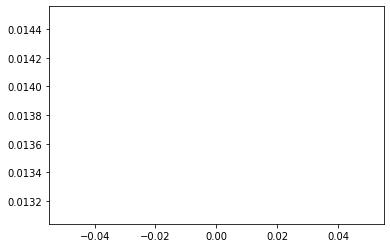

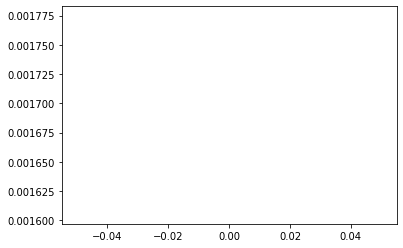

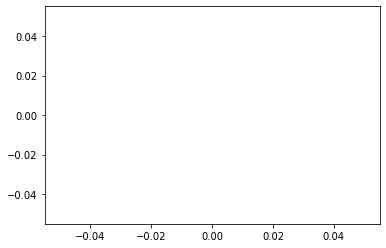

In [ ]:
test = train[0:40000]
f = 'ProductCD'
d = Chi_test(test,f)
a = IG(test,f,'Entropy')
b = IG(test,f,'Gini')
c = IG(test,f,'MisEr')
fig, ax = plt.subplots()
plt.plot(a)
fig, ax = plt.subplots()
plt.plot(b)
fig, ax = plt.subplots()
plt.plot(c)
print (a,b,c,d)

In [104]:
a = Chi_test(test,'C1',2)
a

2.7437641723356005 3.841458820694124


0

In [99]:
test = pd.DataFrame(columns = ['C1','isFraud'])
for i in range(6):
    test.loc[i,'C1'] = 1
test.loc[6,'C1'] = 2
test.loc[7,'C1'] = 3
test.loc[8,'C1'] = 4
test.loc[9,'C1'] = 9
test.iloc[0:10,1] = 0

test.loc[2,'isFraud'] = 1
test.loc[8,'isFraud'] = 1
test.loc[7,'isFraud'] = 1
test = test.sample(frac = 1)
print (test)

  C1 isFraud
1  1       0
4  1       0
7  3       1
3  1       0
6  2       0
8  4       1
9  9       0
0  1       0
2  1       1
5  1       0


In [205]:
a[1]

2.0

In [163]:
test[test[Target] == 1]

TransactionID ProductCD  card1  card2  card3       card4  card5   card6  \
37               38         C  16136  204.0  185.0        visa  138.0   debit   
54               55         W   7815  161.0  150.0  mastercard  117.0   debit   
65               66         C   3213  459.0  185.0        visa  226.0  credit   
90               91         W  13780  298.0  150.0        visa  226.0   debit   
99              100         W   6357  480.0  150.0  mastercard  219.0  credit   
...             ...       ...    ...    ...    ...         ...    ...     ...   
3838           3839         W  17188  321.0  150.0        visa  226.0   debit   
3860           3861         W  12695  490.0  150.0        visa  226.0   debit   
3862           3863         C   5812  408.0  185.0  mastercard  224.0   debit   
3914           3915         W   2947  380.0  150.0        visa  226.0   debit   
3923           3924         C   4329  238.0  185.0        visa  102.0  credit   

         addr1     addr2  ...    C6   C7    C8    C9  C10   C11   C12    C13  \
37    NotFound  NotFound  ...   1.0  1.0   1.0   0.0  1.0   1.0   1.0    1.0   
54       203.0      87.0  ...   3.0  0.0   0.0   1.0  0.0   3.0   0.0    4.0   
65    NotFound  NotFound  ...   1.0  1.0   1.0   0.0  1.0   1.0   1.0    1.0   
90       441.0      87.0  ...   2.0  0.0   0.0   2.0  0.0   2.0   1.0    9.0   
99       485.0      87.0  ...  59.0  0.0   0.0  54.0  0.0  50.0   0.0  442.0   
...        ...       ...  ...   ...  ...   ...   ...  ...   ...   ...    ...   
3838     122.0      87.0  ...   2.0  0.0   0.0   9.0  0.0   3.0   0.0   20.0   
3860     325.0      87.0  ...   2.0  0.0   0.0   3.0  0.0   2.0   0.0    2.0   
3862  NotFound  NotFound  ...   5.0  5.0  11.0   0.0  6.0  11.0  11.0    2.0   
3914     315.0      87.0  ...   1.0  0.0   0.0   1.0  0.0   1.0   0.0    1.0   
3923  NotFound  NotFound  ...   5.0  5.0   4.0   0.0  4.0   5.0   5.0    1.0   

       C14  isFraud  
37     0.0        1  
54     1.0        1  
65     1.0        1  
90     2.0        1  
99    73.0        1  
...    ...      ...  
3838   4.0        1  
3860   1.0        1  
3862   2.0        1  
3914   1.0        1  
3923   1.0        1  

[110 rows x 27 columns]

In [89]:
a_fft = np.fft.fft(a)
conv_array = np.zeros(a_fft.shape)
conv_array[0:5] = 1/10
conv_array[-5:] = 1/10
conv_array[0:5]

array([0.1, 0.1, 0.1, 0.1, 0.1])

(0.0, 100.0)

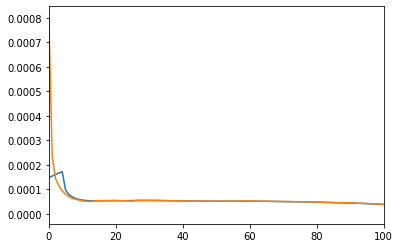

In [120]:
a_fft = np.fft.fft(a)
conv_array = np.zeros(a_fft.shape)
conv_array[0:5] = 1/10
conv_array[-5:] = 1/10
conv_fft = np.fft.fft(conv_array)
a_conv = np.fft.ifft(conv_fft * a_fft).real
a_fft[int(a_fft.shape[0]/10):] = 0
a_ifft = np.abs(np.fft.ifft(a_fft))
#plt.plot(a_ifft)
plt.plot(a_conv)
plt.plot(a)
plt.xlim(0,100)


<font color = red> **Experiment1: </font>** with only 100 random rows

Load data

In [ ]:
# shuffle the train data
train = train.sample(frac = 1)
Exp1_train = train[0:100]
Exp1_train.tail()

TransactionID ProductCD  card1  card2  card3       card4  card5  \
3475             3476         W  15497  490.0  150.0        visa  226.0   
3096             3097         W  17188  321.0  150.0        visa  226.0   
41412           41413         W  12389  532.0  150.0  mastercard  137.0   
252732         252733         W   1214  174.0  150.0        visa  226.0   
429720         429721         C  11436  555.0  150.0        visa  226.0   

         card6     addr1     addr2  ...    C6    C7    C8    C9   C10   C11  \
3475     debit     220.0      87.0  ...   1.0   0.0   0.0   1.0   0.0   1.0   
3096     debit     310.0      87.0  ...   5.0   0.0   0.0   4.0   0.0   5.0   
41412   credit     485.0      87.0  ...  17.0   0.0   0.0  12.0   0.0  11.0   
252732  credit     181.0      87.0  ...   1.0   0.0   0.0   1.0   0.0   1.0   
429720  credit  NotFound  NotFound  ...  16.0  16.0  33.0   0.0  17.0  20.0   

         C12   C13   C14  isFraud  
3475     0.0   1.0   1.0        0  
3096     0.0  29.0   7.0        0  
41412    0.0  77.0  18.0        0  
252732   1.0   3.0   1.0        0  
429720  20.0   2.0   2.0        1  

[5 rows x 27 columns]

Gini index for the Root node

In [ ]:
for i in Columns:
  if i in Categoric_features:

  if i in Numeric_features:




array(['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'TransactionDT', 'TransactionAmt', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'C13', 'C14', 'isFraud'], dtype=object)

<font color = 'green'><b> -------- Leo end --------- </b></font>

<font color = 'Blue'><b> -------- Behnoud start -------- </b></font>

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
train=pd.read_csv('sample_data/train.csv')
test=pd.read_csv('sample_data/test.csv')
train

FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/train.csv'

In [ ]:
def IG_Numeric(Input_Dataframe, Split_feature, IG_methods): #IG_methods = 'Gini'/ 'Entropy' / 'MisEr'
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = len(Fraud_arr[Fraud_arr == 1])/length
  P_notF = 1-P_isF
  Gini_root = 1 - np.power(P_isF,2)  - np.power(P_notF,2)
  Gini_leaves = [] #Gini index of each leaves
  Prop_leaves = [] #Propotion of each leaves
  print ('Pass line 10')
  if Split_feature in Numeric_features:
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    if IG_methods == 'Gini':
      print ('Pass line 15')
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Gini_leaves.append(1 - np.power(Sub_P_isF,2)  - np.power(Sub_P_notF,2))
        Prop_leaves.append(Sub_len/length)
  Gini_root = np.array(Gini_root)
  Prop_leaves = np.array(Prop_leaves)
  IG_feature = Gini_root - np.matmul(Gini_leaves,Prop_leaves.T)

  return IG_feature

In [ ]:
test = train[0:10]
print(IG_Numeric(test,'card4','Gini'))
test

Pass line 3
Pass line 10
0.31999999999999984


TransactionID ProductCD  card1  card2  card3       card4  card5  \
278213         278214         W   8691  599.0  150.0        visa  166.0   
96508           96509         C   2650  142.0  185.0  mastercard  224.0   
396545         396546         W  14259  111.0  150.0        visa  226.0   
366700         366701         W   7919  194.0  150.0  mastercard  202.0   
330372         330373         C   2256  545.0  185.0        visa  226.0   
344300         344301         W  12501  490.0  150.0        visa  226.0   
9200             9201         W   7676  512.0  150.0        visa  226.0   
404371         404372         C  16346  324.0  185.0        visa  226.0   
291138         291139         W  15811  452.0  150.0  mastercard  195.0   
246079         246080         W   9500  321.0  150.0        visa  226.0   

         card6     addr1     addr2  ...   C6   C7   C8   C9  C10  C11  C12  \
278213   debit     226.0      87.0  ...  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
96508    debit  NotFound  NotFound  ...  1.0  1.0  1.0  0.0  2.0  1.0  1.0   
396545   debit     330.0      87.0  ...  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
366700   debit     330.0      87.0  ...  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
330372  credit  NotFound  NotFound  ...  1.0  1.0  2.0  0.0  2.0  1.0  1.0   
344300   debit     204.0      87.0  ...  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
9200     debit     220.0      87.0  ...  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
404371  credit  NotFound  NotFound  ...  2.0  2.0  2.0  0.0  1.0  4.0  4.0   
291138   debit     264.0      87.0  ...  0.0  0.0  0.0  1.0  0.0  3.0  0.0   
246079   debit     204.0      87.0  ...  1.0  0.0  0.0  1.0  0.0  1.0  0.0   

         C13  C14  isFraud  
278213  10.0  3.0        0  
96508    1.0  1.0        0  
396545   1.0  1.0        1  
366700   1.0  1.0        0  
330372   1.0  1.0        0  
344300   1.0  1.0        0  
9200     1.0  1.0        0  
404371   1.0  0.0        1  
291138   7.0  3.0        0  
246079   1.0  1.0        0  

[10 rows x 27 columns]